In [1]:
# general
import argparse
import pickle
import torch
import time
import tempfile
import numpy as np
import random
import os
import wandb
#from ray.rllib.agents import ppo, dqn, pg, a3c, impala
from tqdm import tnrange

# our code
from sigma_graph.envs.figure8.action_lookup import MOVE_LOOKUP, TURN_90_LOOKUP
from sigma_graph.envs.figure8.default_setup import OBS_TOKEN
from sigma_graph.envs.figure8.figure8_squad_rllib import Figure8SquadRLLib
from sigma_graph.envs.figure8.gflow_figure8_squad import GlowFigure8Squad
#from graph_scout.envs.base import ScoutMissionStdRLLib
import sigma_graph.envs.figure8.default_setup as default_setup
import model  # THIS NEEDS TO BE HERE IN ORDER TO RUN __init__.py!
import model.utils as utils
import model.gnn_gflow 
from trajectory import Trajectory
import losses
import torch.optim as optim

2024-02-04 22:40:14,508	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.dqn` has been deprecated. Use `ray.rllib.algorithms.[dqn|simple_q|r2d2|apex_dqn]` instead. This will raise an error in the future!


In [2]:
WANDB = False
SEED = 0
LEARNING_RATE = 1e-3
EPOCHS = 3000
BATCH_SIZE = 100

In [3]:
if WANDB:
    wandb.login()
    wandb.init(
        project="graph-training-simulation",
        config={
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "seed": SEED
        }
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: r-marr747. Use `wandb login --relogin` to force relogin


In [4]:
config = {
    "custom_model": "graph_transformer_policy",
    "custom_model_config": {
        "nred": 1,
        "nblue": 1,
        "aggregation_fn": "agent_node",
        "hidden_size": 10,
        "is_hybrid": False,
        "conv_type": "gcn",
        "layernorm": False,
        "graph_obs_token": {"embed_opt": False, "embed_dir": True},
    },
    "env_config": {
        "env_path": ".",
        "act_masked": True,
        "init_red": None,
        "init_blue": None,
        "init_health_red": 20,
        "init_health_blue": 20,
        "obs_embed": False,
        "obs_dir": False,
        "obs_team": True,
        "obs_sight": False,
        "log_on": False,
        "log_path": "logs/temp/",
        "fixed_start": -1,
        "penalty_stay": 0,
        "threshold_damage_2_blue": 2,
        "threshold_damage_2_red": 5,
    },
}

In [5]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
gflowfigure8 = GlowFigure8Squad(sampler_config=config)

---------------
path_data ./GflowsForSimulation/sigma_graph/data/parsed/
/home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

gflowfigure8 = GlowFigure8Squad(sampler_config=config)

In [8]:
optimizer = optim.AdamW(gflowfigure8.sampler_fcn.parameters(), lr=LEARNING_RATE)

batch_loss = 0
batch_num = 0
batch_reward = 0

for i in range(EPOCHS):
    trajectory = Trajectory()
    gflowfigure8._reset_agents()
    for _ in range(20):   
        for a_id in range(config['custom_model_config']['nred']):
            step = gflowfigure8.step(a_id)
            trajectory.add_step(
                forward_prob=step['forward_prob'],
                backward_prob=step['backward_prob'],
                # flow=step['flow'],
                # action=step['action'],
                reward=step['step_reward'],
                # node=step['node']
            )
    
    episode_loss = losses.Losses.trajectory_balance(trajectory)
    episode_reward = trajectory.rewards

    batch_num = batch_num + 1
    batch_loss += episode_loss
    batch_reward += episode_reward

    if batch_num % BATCH_SIZE == 0:
        if WANDB:
            wandb.log({"loss": batch_loss/BATCH_SIZE, "reward":  batch_reward/BATCH_SIZE})
            batch_loss = 0
            batch_reward = 0
            for name, param in gflowfigure8.sampler_fcn.named_parameters():
                wandb.log({f"{name}_mean": param.data.mean().item(), f"{name}_std": param.data.std().item()})

    episode_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [12]:
gflowfigure8._reset_agents()
state_dirs = {}
for node in range(27):
    states = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    states[0][node] = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(np.array([states[0],], dtype=np.int8)).to(device)
    probs = gflowfigure8.sampler_fcn.forward(state)
    # (forward_prob, action) = gflowfigure8.probs_to_action(probs)
    total_probs = {}
    total_probs["NOOP"] = (probs[0]+probs[5]+probs[10]).tolist()
    total_probs["N"] = (probs[1]+probs[6]+probs[11]).tolist()
    total_probs["S"] = (probs[2]+probs[7]+probs[12]).tolist()
    total_probs["W"] = (probs[3]+probs[8]+probs[13]).tolist()
    total_probs["E"] = (probs[4]+probs[9]+probs[14]).tolist()
    
    state_dirs[node] = total_probs
print(state_dirs)

{0: {'NOOP': 0.17820949651079954, 'N': 0.19639840144099877, 'S': 0.20381606319986284, 'W': 0.2254008692661287, 'E': 0.1961751695822102}, 1: {'NOOP': 0.18217598909235266, 'N': 0.19812147970705368, 'S': 0.19669236652488165, 'W': 0.21663757582996856, 'E': 0.2063725888457435}, 2: {'NOOP': 0.18004291409355228, 'N': 0.19487807413016764, 'S': 0.221700904809441, 'W': 0.19689705364023707, 'E': 0.20648105332660185}, 3: {'NOOP': 0.18169170924137149, 'N': 0.18619650300562068, 'S': 0.22019112569198818, 'W': 0.2079897318416776, 'E': 0.20393093021934208}, 4: {'NOOP': 0.18428485523093124, 'N': 0.1944376562795975, 'S': 0.20081464503836322, 'W': 0.22708909770667018, 'E': 0.19337374574443794}, 5: {'NOOP': 0.19413872073804495, 'N': 0.18301615324898782, 'S': 0.20584071761857042, 'W': 0.23640976764821833, 'E': 0.18059464074617837}, 6: {'NOOP': 0.1858327918118302, 'N': 0.16176891499626472, 'S': 0.22773962216945004, 'W': 0.25647981870644243, 'E': 0.16817885231601246}, 7: {'NOOP': 0.18215174715508717, 'N': 0.1

In [28]:
trajectory = Trajectory()
gflowfigure8._reset_agents()
for _ in range(20):   
    for a_id in range(config['custom_model_config']['nred']):
        step = gflowfigure8.step(a_id)
        trajectory.add_step(
            forward_prob=step['forward_prob'],
            backward_prob=step['backward_prob'],
            # flow=step['flow'],
            # action=step['action'],
            reward=step['step_reward'],
            # node=step['node']
        )
        print(step['node'])
        print(step['action'])


25
[[4, 1]]
25
[[0, 0]]
25
[[0, 1]]
25
[[2, 1]]
8
[[0, 1]]
8
[[1, 1]]
14
[[0, 2]]
14
[[0, 0]]
14
[[4, 2]]
14
[[2, 0]]
8
[[0, 0]]
8
[[1, 2]]
14
[[1, 2]]
20
[[1, 1]]
20
[[1, 0]]
20
[[1, 0]]
20
[[0, 2]]
20
[[0, 0]]
20
[[4, 1]]
26
[[2, 0]]


log_file log_done_0
log_file log_done_0.txt
---------------
path_data ../GflowsForSimulation/sigma_graph/data/parsed/
/home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation
line Step # 1 | red:0 HP:5 node:25 dir:4 pos:(11, 6) | blue:1 HP:5 node:24 dir:1 pos:(14, 11) | Actions:[[[1, 0]]] | Step rewards:[0]

segments ['Step # 1', 'red:0 HP:5 node:25 dir:4 pos:(11, 6)', 'blue:1 HP:5 node:24 dir:1 pos:(14, 11)', 'Actions:[[[1, 0]]]', 'Step rewards:[0]\n']
line Step # 1 | red:0 HP:5 node:25 dir:4 pos:(11, 6) | blue:1 HP:5 node:24 dir:1 pos:(14, 11) | Actions:[[[1, 0]]] | Step rewards:[0]

segments ['Step # 1', 'red:0 HP:5 node:25 dir:4 pos:(11, 6)', 'blue:1 HP:5 node:24 dir:1 pos:(14, 11)', 'Actions:[[[1, 0]]]', 'Step rewards:[0]\n']
line Step # 2 | red:0 HP:5 node:11 dir:1 pos:(12, 6) | blue:1 HP:5 node:22 dir:4 pos:(14, 10) | Actions:[[[2, 2]]] | Step rewards:[0]

segments ['Step # 2', 'red:0 HP:5 node:11 dir:1 pos:(12, 6)', 'blue:1 HP:5 node:22 dir:4 pos:(14, 10)', 'Actions:[[

KeyboardInterrupt: 

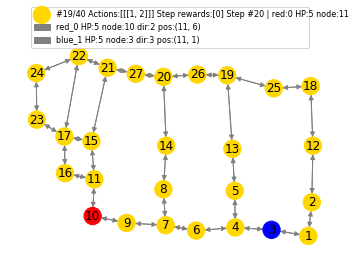

In [25]:
import argparse
import glob
import os
import re

import networkx as nx
import numpy as np
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
from sigma_graph.data.file_manager import check_dir, find_file_in_dir, load_graph_files

def agent_log_parser(line) -> dict:
    agent_info = {}
    # parse team info
    team_red = re.search(r"red:(\d+)", line)
    team_blue = re.search(r"blue:(\d+)", line)
    if team_red is not None:
        agent_info["team"] = "red"
        agent_info["id"] = team_red[1]
    elif team_blue is not None:
        agent_info["team"] = "blue"
        agent_info["id"] = team_blue[1]
    else:
        assert f"[log] Invalid agent team format: {line}"
    # parse agent info
    agent_pos = re.search(r"HP:\s?(\d+) node:(\d+) dir:(\d) pos:\((\d+), (\d+)\)", line)
    if agent_info is not None:
        agent_info["HP"] = int(agent_pos[1])
        agent_info["node"] = int(agent_pos[2])
        agent_info["dir"] = int(agent_pos[3])
        agent_info["pos"] = (int(agent_pos[4]), int(agent_pos[5]))
    else:
        assert f"[log] Invalid agent info format: {line}"
    return agent_info


def list_nums_log_parser(line):
    pass


def log_file_parser(line):
    print(f'line {line}')
    segments = line.split(" | ")
    print(f'segments {segments}')
    step_num = int(re.search(r"Step #\s?(\d+)", segments[0])[1])

    agents = []
    for str_agents in segments[1:-2]:
        agents.append(agent_log_parser(str_agents))
    actions = segments[-2]
    rewards = segments[-1]

    return step_num, agents, actions, rewards[:-1]


def check_log_files(env_dir, log_dir, log_file):
    # generate a subfolder in the log folder for -> animations (and optional pictures for each step)
    log_file_dir = find_file_in_dir(log_dir, log_file)
    fig_file_dir = os.path.join(log_dir, log_file[:-4])
    if not check_dir(fig_file_dir):
        os.mkdir(fig_file_dir)
    return log_file_dir, fig_file_dir


def generate_picture(env_dir, log_dir, log_file, HP_red, TR_red, HP_blue, TR_blue,
                     color_decay=True, if_froze=False, max_step=40, map_lookup="S"):
    # check file existence
    log_file_dir, fig_folder = check_log_files(env_dir, log_dir, log_file)
    map_info, _ = load_graph_files(env_path=env_dir, map_lookup=map_lookup)
    # load log info
    file = open(log_file_dir, 'r')
    lines = file.readlines()

    # predetermined colors
    col_map_red = ['#200000', '#200000', '#400000', '#800000', '#BF0000', '#FF0000']
    col_map_blue = ['#000020', '#000020', '#000040', '#000080', '#0000BF', '#0000FF']
    if color_decay:
        HP_offset = 0.1
        red_bds = np.append([0], np.linspace(HP_red - TR_red + HP_offset, HP_red + HP_offset, num=len(col_map_red)))
        red_norm = colors.BoundaryNorm(boundaries=red_bds, ncolors=len(col_map_red))
        blue_bds = np.append([0], np.linspace(HP_blue - TR_blue, HP_blue + HP_offset, num=len(col_map_blue)))
        blue_norm = colors.BoundaryNorm(boundaries=blue_bds, ncolors=len(col_map_blue))
    else:
        red_norm = lambda x: -1
        blue_norm = lambda x: -1

    total_reward = 0
    pause_step = 0

    for i, line in enumerate(lines):
        fig = plt.figure()
        # set figure background opacity (alpha) to 0
        fig.patch.set_alpha(0.)
        fig.tight_layout()
        plt.axis('off')

        if i < max_step:
            idx_step, agents, action, reward = log_file_parser(line)
            text_head = f"#{idx_step:2d}/{max_step} {action} {reward} "
        elif i == max_step:
            # get episode rewards from log
            text_head += line[:-1]
        legend_text = [text_head]
        # set color map for agents and waypoints
        col_map = ["gold"] * len(map_info.n_info)
        for agent in agents:
            legend_text += ["{}_{} HP:{} node:{} dir:{} pos:{}".format(agent["team"], agent["id"], agent["HP"],
                                                                       agent["node"], agent["dir"], agent["pos"])]
            if agent["team"] == 'red':
                col_map[agent['node'] - 1] = "red" #col_map_red[red_norm(agent['HP'])]
            elif agent["team"] == 'blue':
                blue_health = agent['HP']
                col_map[agent['node'] - 1] = "blue" #col_map_blue[blue_norm(blue_health)]
        # set pause frame number for gif looping
        if if_froze and (not pause_step) and (blue_health <= HP_blue - TR_blue):
            pause_step = i
        # render fig and save to png
        nx.draw_networkx(map_info.g_acs, map_info.n_info, node_color=col_map, edge_color="grey", arrows=True)
        plt.legend(legend_text, bbox_to_anchor=(0.07, 0.95, 0.83, 0.1), loc='lower left', prop={'size': 8},
                   mode="expand", borderaxespad=0.)
        plt.savefig(os.path.join(fig_folder, f"{i:03d}.png"), dpi=100, transparent=True)
        plt.close()
    return fig_folder, pause_step


def generate_picture_route(env_dir, log_dir, log_file, route_info):
    log_file_dir, fig_folder = check_log_files(env_dir, log_dir, log_file)
    return fig_folder


def frame_add_background(img_dir, gif_file, bg_file, fps, stop_frame=0, wait_frame=5):
    img_files = img_dir + "/*.png"
    imgs = []
    frames = 0
    for f in sorted(glob.glob(img_files)):
        foreground = Image.open(f)
        background = Image.open(bg_file)
        background.paste(foreground, (0, 0), foreground)
        imgs.append(background)
        if stop_frame:
            if frames == stop_frame:
                break
            frames += 1
    # set up additional end frames before looping
    if not stop_frame:
        for i in range(wait_frame):
            imgs.append(imgs[-1])
    imgs[0].save(fp=gif_file, format='GIF', append_images=imgs[1:],
                 save_all=True, duration=(1000 // fps), loop=(stop_frame > 0))


def local_run(env_dir, log_dir, prefix, bg_pic, fps, HP_red, TR_red, HP_blue, TR_blue,
              color_decay=True, froze=False, route_only=False, route_info=None):
    directory = os.fsencode(log_dir)
    for file in os.listdir(directory):
        log_file = os.fsdecode(file)
        print(f'log_file {log_file}')
        if log_file.endswith(".txt") and log_file.startswith(prefix):
            if route_only:
                fig_folder = generate_picture_route(env_dir, log_dir, log_file, route_info)
                pause_frame = 0
            else:
                fig_folder, pause_frame = generate_picture(env_dir, log_dir, log_file,
                                                           HP_red, TR_red, HP_blue, TR_blue, color_decay, froze)
            frame_add_background(fig_folder, os.path.join(log_dir, f"{log_file[:-4]}.gif"), bg_pic, fps,
                                 pause_frame)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--env_dir', type=str, default='../../', help='path to project root')
    parser.add_argument('--log_dir', type=str, default='../../logs/visuals/demo/', help='path to log file folder')
    parser.add_argument('--prefix', type=str, default='log_', help='log file prefix')
    parser.add_argument('--background', type=str, default='../../logs/visuals/background.png')
    parser.add_argument('--fps', type=int, default=2)  # frame per second in animations

    parser.add_argument('--HP_froze_on', action='store_true', default=False, help='stop animation if agent is dead')
    parser.add_argument('--HP_red', type=int, default=100)
    parser.add_argument('--TR_red', type=int, default=5)
    parser.add_argument('--HP_blue', type=int, default=100)
    parser.add_argument('--TR_blue', type=int, default=10)
    parser.add_argument('--HP_color_off', action='store_false', default=True, help='gradient colors for HP')

    parser.add_argument('--route_only', type=bool, default=False)  # exclude step info
    parser.add_argument('--route_info', type=str, default='name')  # choose from ['name', 'pos', 'idx']
    args = parser.parse_args(args=['--log_dir', '../logs/temp', '--env_dir', '../', '--background', '../logs/background.png'])

    local_run(args.env_dir, args.log_dir, args.prefix, args.background, args.fps,
              args.HP_red, args.TR_red, args.HP_blue, args.TR_blue, args.HP_color_off,
              args.HP_froze_on, args.route_only, args.route_info)